# Tema d'esame 03-02-2023


In [47]:
import numpy as np
import scipy.stats as sc
from scipy.stats import norm
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/gio/Desktop/LaboratorioCalcoloEStatistica/")
from mylib.matstyle import hist_style
from mylib.basics import sturges

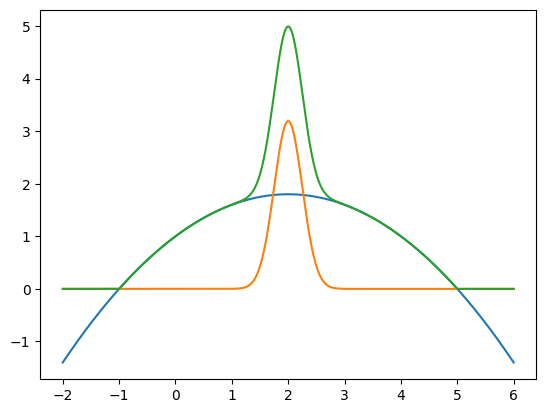

In [48]:
def theta(x,a,b):
    if type(x) == np.ndarray or type(x) == list:
        return np.array([1 if a <= i and b>= i else 0 for i in x])
    else: return 1 if a <= x and b>= x else 0

def parabola(x,a,b,c):
    return a*x**2 + b*x + c

fix_parabola = lambda x: parabola(x,-0.2,0.8,1)

mynorm = norm(loc = 2, scale = 0.25)
fix_norm = lambda x: 2 * mynorm.pdf(x)

f = lambda x: (fix_parabola(x) + fix_norm(x)) * theta(x,-1,5)

X = np.linspace(-2,6,1000)
plt.plot(X,fix_parabola(X))
plt.plot(X,fix_norm(X))
plt.plot(X,f(X))
plt.show()

In [49]:
def rand_uniform(min,max,size=1):
    if size==1: return np.float64(np.random.rand()*(max-min) + min)
    return np.random.rand(size)*(max-min) + min

def rand_TAC(pdf,xmin,xmax,ymax,size=1):
    l = np.empty(size,dtype=np.float64)
    for i in range(size):
        randX = rand_uniform(xmin,xmax,size=1)
        while pdf(randX) < rand_uniform(0,ymax,size=1):
            randX = rand_uniform(xmin,xmax,size=1)
        l[i] = randX
    return l[0] if size == 1 else l

from mylib.integrals import crude_montecarlo

In [54]:
area_norm = crude_montecarlo(fix_norm,-1,5)[0]
area_para = crude_montecarlo(fix_parabola,-1,5)[0]
area_tot = crude_montecarlo(f,-1,5)[0]
print(area_norm,area_para)
print(area_tot)

Psig = area_norm/area_tot
Pbkg = area_para/area_tot
print(Psig,Pbkg)

pdf = lambda x: f(x)/area_tot

1.9958658928205937 7.206408524955686
9.200540380622758
0.21692920309594893 0.7832592681331076


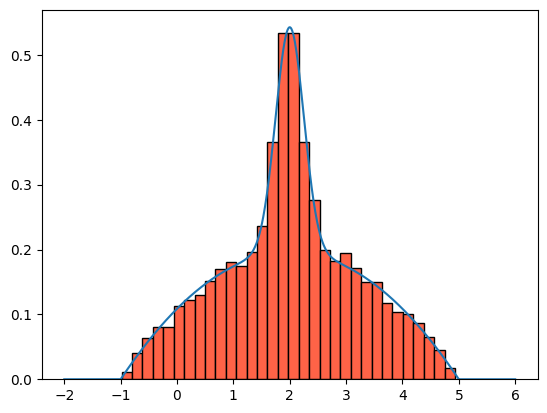

In [67]:
N = 10000
data = rand_TAC(pdf,-1,7,1,size=N)
plt.hist(data, bins = sturges(N), edgecolor='black', color='tomato',density=True) #,**hist_style(len(data))
plt.plot(X,pdf(X))
plt.show()

In [68]:
# NORM CDF AREA
# print(crude_montecarlo(lambda x: norm.cdf(x,loc=0,scale=1),-10,10))

(10.013106433635631, 0.00941881193068568)


## Parameters estimation:

In [65]:
from iminuit.cost import ExtendedBinnedNLL
from iminuit import Minuit

def parabola_cdf(x,a,b,c):
    return (a/3) * (x**3) + (b/2) * (x**2) + c*x

def mod_total (bin_edges,Nsig,Nbkg,m,s, normal,a,b,c):
    return Nbkg * parabola_cdf(bin_edges,a,b,c) + Nsig * normal * norm.cdf(bin_edges,loc=m,scale=s,)

datap = data # np.concatenate([data[data < 0], data[data > 4]])
bin_edges = np.linspace(np.min(datap),np.max(datap),sturges(N))
bin_content = np.array([len(datap[(datap>i)*(datap<=g)]) for i,g in zip(bin_edges[:-1],bin_edges[1:])])
my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, mod_total)
my_minuit = Minuit(
    my_cost_func,
    Nsig=N/2,Nbkg=N/2,
    m=np.mean(datap),normal=2,s=np.std(datap),
    a=1,b=1,c=1
    )

my_minuit.migrad()
print(my_minuit.valid)
display(my_minuit)

False


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.739e+04 (χ²/ndof = 1159.2)│             Nfcn = 1840              │
│ EDM = nan (Goal: 0.0002)         │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nsig   │ -4.4204e1 │    nan    │            │            │         │         │       │
│ 1 │ Nbkg   │ 3.7065e2  │    nan    │            │            │         │         │       │
│ 2 │ m      │  2.3002   │    nan    │            │            │         │         │       │
│ 3 │ s      │  1.2237   │    nan    │            │            │         │         │       │
│ 4 │ normal │     2     │    nan    │            │            │         │         │       │
│ 5 │ a      │ 2.5726e-1 │    nan    │            │            │         │         │       │
│ 6 │ b      │  1.1102   │    nan    │            │            │         │         │       │
│ 7 │ c      │  1.4371   │    nan    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────┐
│        │   Nsig   Nbkg      m      s normal      a      b      c │
├────────┼─────────────────────────────────────────────────────────┤
│   Nsig │    nan    nan    nan    nan    nan    nan    nan    nan │
│   Nbkg │    nan    nan    nan    nan    nan    nan    nan    nan │
│      m │    nan    nan    nan    nan    nan    nan    nan    nan │
│      s │    nan    nan    nan    nan    nan    nan    nan    nan │
│ normal │    nan    nan    nan    nan    nan    nan    nan    nan │
│      a │    nan    nan    nan    nan    nan    nan    nan    nan │
│      b │    nan    nan    nan    nan    nan    nan    nan    nan │
│      c │    nan    nan    nan    nan    nan    nan    nan    nan │
└────────┴─────────────────────────────────────────────────────────┘